# LoRA MNIST Finetuning

## Project Setup

### Notebook Setup Instructions

Ensure the following prerequisites are installed and configured:

1. **Python**  
    **Version Required:** Python 3.12.8  
    Download and install Python: [Download Python 3.12.8](https://www.python.org/downloads/release/python-3128/)

### Install Required Dependencies

In [77]:
# Check if the variable `dependencies_installed` exists and is True
if not globals().get("dependencies_installed", False):
    # Install the required packages
    %pip install pytorch_lightning
    %pip install torchmetrics

    # Set the flag to True after successful installation
    dependencies_installed = True
    print("Dependencies installed successfully.")
else:
    print("Dependencies are already installed, skipping installation.")


Dependencies are already installed, skipping installation.


### Import Libraries and Modules

In [78]:
# Check if the variable `modules_imported` exists and is True
if not globals().get("modules_imported", False):
    # Import the required modules
    import math
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import pytorch_lightning as pl
    import torch
    import torchmetrics
    import torchvision
    
    from torch import nn
    from torch.utils.data import Dataset, DataLoader, random_split
    from torchmetrics.classification import Accuracy
    from torchvision import transforms
    from torchvision.datasets import MNIST
    from pytorch_lightning import Trainer
    from pytorch_lightning.loggers import TensorBoardLogger
    from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping

    # Set the flag to True after successful imports
    modules_imported = True
    print("Modules imported successfully.")
else:
    print("Modules are already imported, skipping import.")


Modules are already imported, skipping import.


### Directory Setup

In [79]:
# Set directories for project
data_dir = "./data"

# Define subdirectories
logs_dir = os.path.join(data_dir, "logs")
checkpoints_dir = os.path.join(data_dir, "checkpoints")

# Ensure all directories exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)


### Parameters

In [80]:
# Training parameters
batch_size = 64
val_split = 0.2
max_epochs = 1

# Base and LoRA specific digit sets for MNIST
digits_base = list(range(5))  # Digits 0-4 for base model training
digits_lora = list(range(5, 10))  # Digits 5-9 for LoRA finetuning


### Configurations

In [81]:
# Adjust matrix multiplication precision for Tensor Cores
torch.set_float32_matmul_precision('medium')

# Training configurations
precision='16-mixed'  # Enable mixed precision training
enable_checkpointing = False  # Set to True to enable automatic checkpoint saving
num_sanity_val_steps = 0  # Set to 0 to bypass sanity checking


### Debugging Configurations

In [82]:
# Debug parameters
debug = True
if debug:
    # Check for CUDA availability
    if torch.cuda.is_available():
        print(f"CUDA is available on device {torch.cuda.current_device()}")

    # Print base and LoRA digits configuration
    print(f"Digits (base): {digits_base}")
    print(f"Digits (LoRA): {digits_lora}")


CUDA is available on device 0
Digits (base): [0, 1, 2, 3, 4]
Digits (LoRA): [5, 6, 7, 8, 9]


### Paths

In [83]:
# Define model saving paths for the base model
model_base_ckpt = os.path.join(checkpoints_dir, "model_base.ckpt")
model_base_pt = os.path.join(checkpoints_dir, "model_base.pt")


### Utility Functions

In [84]:
def get_batch_from_dataset(datamodule, batch_size=5, setup_stage="test", shuffle=True):
    """
    Get a batch of data from the dataset using the appropriate dataloader for the specified stage.

    Parameters:
        - datamodule: The PyTorch Lightning DataModule instance containing the dataset.
        - batch_size: The number of samples to retrieve.
        - setup_stage: Specifies the dataset split stage ("train", "val", "test").

    Returns:
        - x: The batch of input data.
        - y: The batch of labels corresponding to x.
    """
    # Ensure the dataset is loaded for the correct stage
    datamodule.setup(stage=setup_stage)

    # Retrieve the appropriate dataloader for the specified stage
    if setup_stage == "train":
        dataloader = datamodule.train_dataloader(batch_size=batch_size, shuffle=shuffle)
    elif setup_stage == "val":
        dataloader = datamodule.val_dataloader(batch_size=batch_size, shuffle=shuffle)
    elif setup_stage == "test":
        dataloader = datamodule.test_dataloader(batch_size=batch_size, shuffle=shuffle)
    else:
        raise ValueError(f"Invalid setup_stage '{setup_stage}'. Choose from 'train', 'val', or 'test'.")

    # Fetch one batch of data
    x, y = next(iter(dataloader))

    return x, y

def visualize_batch(x, y, title="Batch Visualization", fig_size=(12, 3)):
    """
    Visualize a batch of images along with their labels.

    Parameters:
        - x: A batch of images (tensor) to display.
        - y: The corresponding labels (tensor) of the images.
        - title: The title of the plot.
        - fig_size: The size of the plot.
    """
    # Get the batch size
    batch_size = len(x)
    
    # Set up the plotting grid
    fig, axes = plt.subplots(1, batch_size, figsize=fig_size)
    
    # Loop over the batch and display each image with its label
    for i in range(batch_size):
        axes[i].imshow(x[i].squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {y[i].item()}", fontsize=10)
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_batch_with_predictions(model, x, y, title="Batch Visualization with Predictions", fig_size=(12, 3)):
    """
    Visualize a batch of images, their true labels, and the predicted labels from the model.

    Parameters:
        - model: The model to use for making predictions on the batch.
        - x: A batch of images (tensor) to display.
        - y: The corresponding true labels (tensor) of the images.
        - title: The title of the plot.
        - fig_size: The size of the plot.
    """
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Get model predictions without computing gradients
    with torch.no_grad():
        predictions = model(x)
        
    # Get the predicted labels by selecting the class with the highest logit value
    predicted_labels = predictions.argmax(dim=1)

    # Get the batch size
    batch_size = len(x)
    
    # Set up the plotting grid
    fig, axes = plt.subplots(1, batch_size, figsize=fig_size)
    
    # Loop over the batch and display each image with its true and predicted labels
    for i in range(batch_size):
        axes[i].imshow(x[i].squeeze(), cmap="gray")
        axes[i].set_title(f"True: {y[i].item()} | Pred: {predicted_labels[i].item()}", fontsize=10)
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


### Example:

```python
# Get a batch of data from the dataset
x, y = get_batch_from_dataset(datamodule=dm_lora, batch_size=5, setup_stage="test")

# Visualize the batch with labels
visualize_batch(x, y, title="Batch Sample", fig_size=(12, 3))

# Visualize the batch with predicted and true labels
visualize_batch_with_predictions(model=model, x=x, y=y, title="Batch with Predictions", fig_size=(12, 3))
```


## Model Definition and Setup

### Dataset

In [85]:
class MNISTDataset(Dataset):
    """
    Custom MNIST Dataset for filtering and transforming data.
    
    Args:
        data_dir (str): Directory to store/load MNIST data.
        train (bool): Whether to load the training set (True) or test set (False).
        download (bool): Whether to download the dataset if not already present.
        digits (list[int] or None): A list of digits to filter. If None, all digits are included.
        transform (callable or None): Transformation to apply to images.
    """
    def __init__(self, data_dir, train, download=True, digits=None, transform=None):
        self.data_dir = data_dir
        self.digits = digits
        self.transform = transform

        # Download MNIST dataset if not already present
        self.dataset = MNIST(self.data_dir, train=train, download=download, transform=transform)
        
        # Filter dataset by digits if specified
        if self.digits is not None:
            self.dataset = self._filter_digits(self.dataset)

    def _filter_digits(self, dataset):
        """
        Filter the dataset to only include specific digits.

        Args:
            dataset (Dataset): The dataset object.
        
        Returns:
            dataset (Dataset): Filtered dataset containing only the specified digits.
        """
        mask = [label in self.digits for label in dataset.targets]
        dataset.data = dataset.data[mask]
        dataset.targets = dataset.targets[mask]
        return dataset

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Get a sample from the dataset at the given index.
        """
        return self.dataset[index]


### DataModule

In [86]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64, val_split=0.2, digits=None):
        """
        PyTorch Lightning DataModule for MNIST Dataset.

        Args:
            data_dir (str): Path to store/load MNIST data.
            batch_size (int): Batch size for DataLoader.
            val_split (float): Fraction of training data to use for validation.
            digits (list[int] or None): A list of digits to select. If None, all digits are included.
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.digits = digits

        # Transformations applied to dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
        
    def prepare_data(self):
        """
        Ensure the MNIST dataset is downloaded.
        """    
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        """
        Prepares datasets and splits them into train, validation, and test sets.
        """
        if stage == "train" or stage == "val" or stage is None:
            # Load full train set
            full_train = MNISTDataset(self.data_dir, train=True, digits=self.digits, transform=self.transform)

            # Calculate split sizes for train and validation
            self.train_size = int((1 - self.val_split) * len(full_train))
            self.valid_size = len(full_train) - self.train_size

            # Randomly split the data into train and validation
            self.train_data, self.valid_data = random_split(full_train, [self.train_size, self.valid_size])

        if stage == "test" or stage is None:
            # Load the test dataset
            self.test_data = MNISTDataset(self.data_dir, train=False, digits=self.digits, transform=self.transform)

    def train_dataloader(self, batch_size=None, shuffle=True):
        batch_size = batch_size or self.batch_size
        return DataLoader(self.train_data, batch_size=batch_size, shuffle=shuffle)
    
    def val_dataloader(self, batch_size=None, shuffle=False):
        batch_size = batch_size or self.batch_size
        return DataLoader(self.valid_data, batch_size=batch_size, shuffle=shuffle)
    
    def test_dataloader(self, batch_size=None, shuffle=False):
        batch_size = batch_size or self.batch_size
        return DataLoader(self.test_data, batch_size=batch_size, shuffle=shuffle)


### Model

In [87]:
class MNISTModel(pl.LightningModule):
    def __init__(self, lr=1e-3, dims=(1, 28, 28), num_classes=10, hidden_size=64):
        """
        Initialize the MNIST model.

        Args:
            lr (float): Learning rate for the optimizer.
            dims (tuple): Dimensions of input images, default (1, 28, 28).
            num_classes (int): Number of output classes for classification. Defaults to 10 for MNIST.
            hidden_size (int): Size of hidden layers.
        """
        super().__init__()
        self.lr = lr
        self.dims = dims
        self.num_classes = num_classes
        self.hidden_size = hidden_size

        # Define the model structure
        self.model = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.dims[0] * self.dims[1] * self.dims[2], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.num_classes)
        )

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Accuracy metric
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def common_step(self, batch, batch_idx, stage):
        """
        Defines a common step for training, validation, and testing.
        """
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
    
        # Log metrics dynamically based on the stage
        self.log(f"{stage}_loss", loss, on_step=(stage == "train"), on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc", self.accuracy(logits, y), on_step=(stage == "train"), on_epoch=True, prog_bar=True)
    
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, stage="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="val")
    
    def test_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="test")


### Initialization

In [106]:
# Initialize the logger
tb_logger = TensorBoardLogger(logs_dir, name='mnist')

# Initialize the model_base
model_base = MNISTModel()

# Initialize the DataModule
dm_base = MNISTDataModule(data_dir=data_dir, batch_size=batch_size, val_split=val_split, digits=digits_base)
dm_lora = MNISTDataModule(data_dir=data_dir, batch_size=batch_size, val_split=val_split, digits=digits_lora)
dm_full = MNISTDataModule(data_dir=data_dir, batch_size=batch_size, val_split=val_split)


### Check Sample

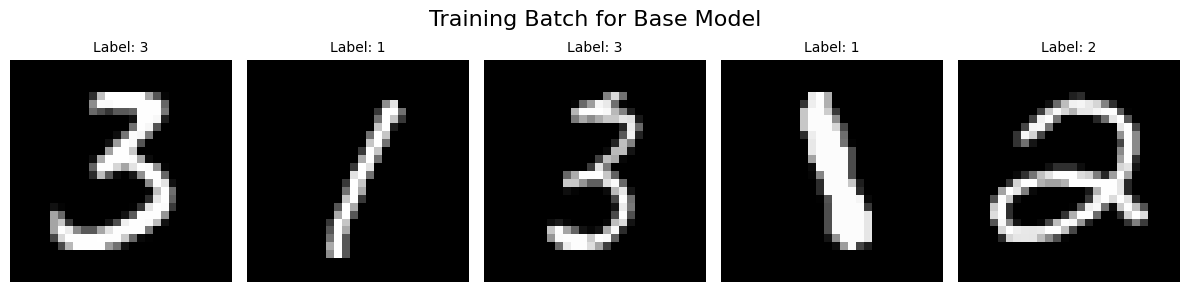

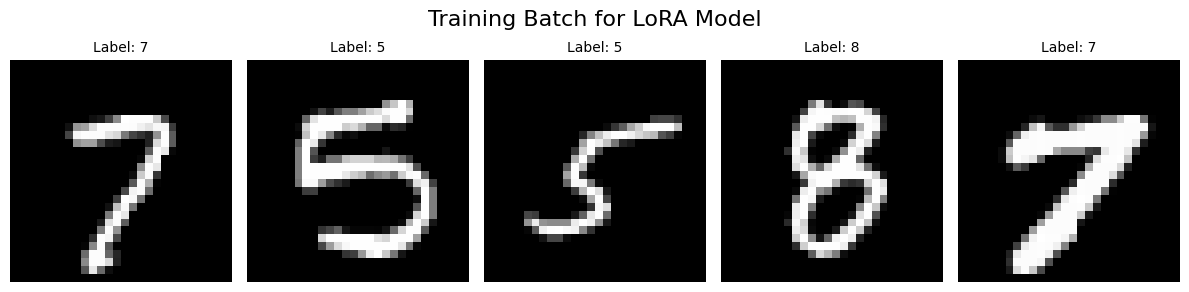

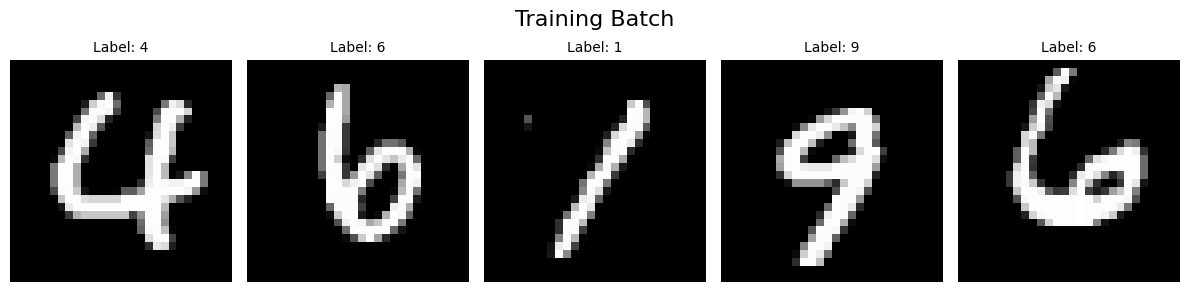

In [107]:
# Visualize a batch of training data from the 'base' datamodule
x, y = get_batch_from_dataset(datamodule=dm_base, batch_size=5, setup_stage="train")
visualize_batch(x, y, title="Training Batch for Base Model")

# Visualize a batch of training data from the 'lora' datamodule
x, y = get_batch_from_dataset(datamodule=dm_lora, batch_size=5, setup_stage="train")
visualize_batch(x, y, title="Training Batch for LoRA Model")

# Visualize a batch of training data from the 'full' datamodule
x, y = get_batch_from_dataset(datamodule=dm_full, batch_size=5, setup_stage="train")
visualize_batch(x, y, title="Training Batch")


### Training

In [90]:
# Trainer setup
trainer = Trainer(
    max_epochs=max_epochs,
    accelerator='auto',
    devices='auto',
    precision=precision,
    logger=tb_logger,
    enable_checkpointing=enable_checkpointing,
    num_sanity_val_steps=num_sanity_val_steps,
)

# Fit the model_base
trainer.fit(model_base, dm_base)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 55.1 K | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
C:\Users\NightFore\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wor

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.


### Testing

In [91]:
# Test the base model on the base dataset
trainer.test(model_base, dm_base)

# Test the base model on the lora dataset (Expected to fail)
trainer.test(model_base, dm_lora)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\NightFore\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9725627303123474     │
│         test_loss         │    0.08791767805814743    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.0            │
│         test_loss         │    11.511431694030762     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 11.511431694030762, 'test_acc': 0.0}]

### Saving and Checkpointing

In [92]:
    # Save model weights so we can finetune them later
    trainer.save_checkpoint(model_base_ckpt)
    torch.save(model_base.state_dict(), model_base_pt)

## LoRA Fine-Tuning

### LoRA Model

In [93]:
class MNISTLoRA(pl.LightningModule):
    def __init__(self, lr=1e-3, dims=(1, 28, 28), num_classes=10, hidden_size=64, lora_rank=8, lora_alpha=1):
        """
        Initialize the MNIST model with LoRA modifications.

        Args:
            lr (float): Learning rate for the optimizer.
            dims (tuple): Dimensions of input images, default (1, 28, 28).
            num_classes (int): Number of output classes for classification. Defaults to 10 for MNIST.
            hidden_size (int): Size of hidden layers.
            lora_rank (int): Rank for LoRA layers.
            lora_alpha (float): Scaling factor for LoRA adaptation.
        """
        super().__init__()
        self.lr = lr
        self.dims = dims
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.lora_rank = lora_rank
        self.lora_alpha = lora_alpha

        # Define the model structure
        self.model = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.dims[0] * self.dims[1] * self.dims[2], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.num_classes)
        )
        
        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Accuracy metric
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)
        
        # LoRA parameters (for layers 1, 2, and 3)
        self.l1_lora_A = nn.Parameter(torch.empty(self.dims[0] * self.dims[1] * self.dims[2], self.lora_rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))
        self.l2_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))
        self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))

        # Initialize LoRA parameters
        for n, p in self.named_parameters():
            if 'lora' in n:
                if n[-1] == 'A':
                    nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                elif n[-1] == 'B':
                    nn.init.zeros_(p)

        # Freeze non-LoRA parameters (only train the LoRA layers)
        for n, p in self.named_parameters():
            if 'lora' not in n:
                p.requires_grad = False

    def lora_linear(self, x, layer, lora_A, lora_B):
        """
        Performs a forward pass through a layer, augmented with LoRA.
        """
        h = layer(x)
        h += x @ (lora_A @ lora_B) * self.lora_alpha
        return h

    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = self.model[0](x)
        x = self.lora_linear(x, self.model[1], self.l1_lora_A, self.l1_lora_B)
        x = self.model[2](x)
        x = self.lora_linear(x, self.model[3], self.l2_lora_A, self.l2_lora_B)
        x = self.model[4](x)
        x = self.lora_linear(x, self.model[5], self.l3_lora_A, self.l3_lora_B)
        return x

    def configure_optimizers(self):
        """
        Configure the optimizer and learning rate scheduler.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            },
        }
    
    def common_step(self, batch, batch_idx, stage):
        """
        Defines a common step for training, validation, and testing.
        """
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
    
        # Log metrics dynamically based on the stage
        self.log(f"{stage}_loss", loss, on_step=(stage == "train"), on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc", self.accuracy(logits, y), on_step=(stage == "train"), on_epoch=True, prog_bar=True)
    
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, stage="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="val")
    
    def test_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="test")


### Fine-Tuning

In [111]:
def lora_experiment(model_checkpoint, lora_class, lora_rank, datamodule, max_epochs=10, checkpoint_dir="./checkpoints"):
    """
    Fine-tune a model using LoRA with a specific rank.

    Args:
        model_checkpoint (str): Path to the pre-trained model checkpoint.
        lora_class (Type[pl.LightningModule]): LoRA model class to use.
        lora_rank (int): Rank for LoRA fine-tuning.
        datamodule (pl.LightningDataModule): PyTorch Lightning DataModule for training/testing.
        max_epochs (int): Maximum number of epochs for training. Default is 10.
        checkpoint_dir (str): Directory to save model checkpoints. Default is "checkpoints".

    Returns:
        Tuple[pl.LightningModule, float]: Trained LoRA model and test accuracy after fine-tuning.
    """
    # Load the pre-trained model
    state_dict = torch.load(model_checkpoint)
    model = lora_class(lora_rank=lora_rank)
    model.load_state_dict(state_dict, strict=False)
    
    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator='auto',
        devices='auto',
        precision=precision,
        logger=tb_logger,
        enable_checkpointing=enable_checkpointing,
        num_sanity_val_steps=num_sanity_val_steps,
        enable_model_summary=False,
    )

    # Fine-tune the model
    print(f"\nStarting LoRA fine-tuning with rank={lora_rank}...")
    trainer.fit(model, datamodule)

    # Evaluate on the test set
    result = trainer.test(model, datamodule, verbose=False)
    test_acc = result[0]['test_acc']
    print(f"LoRA Rank {lora_rank} - Test Accuracy: {test_acc:.4f}")
    
    # Save the model at the end
    trainer.save_checkpoint(f"{checkpoint_dir}/model_lora_rank_{lora_rank}.ckpt")

    return model, test_acc


C:\Users\NightFore\AppData\Local\Temp\ipykernel_135644\4107360755.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_checkpoint)
Using 16bit 


Starting LoRA fine-tuning with rank=1...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LoRA Rank 1 - Test Accuracy: 0.5493

Starting LoRA fine-tuning with rank=2...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LoRA Rank 2 - Test Accuracy: 0.6591

Starting LoRA fine-tuning with rank=4...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LoRA Rank 4 - Test Accuracy: 0.8256

Starting LoRA fine-tuning with rank=8...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LoRA Rank 8 - Test Accuracy: 0.8980

Starting LoRA fine-tuning with rank=16...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LoRA Rank 16 - Test Accuracy: 0.9136

Starting LoRA fine-tuning with rank=32...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LoRA Rank 32 - Test Accuracy: 0.9327

Starting LoRA fine-tuning with rank=64...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

LoRA Rank 64 - Test Accuracy: 0.9329


### Experiment (LoRA Dataset)

In [ ]:
# Run LoRA fine-tuning for multiple ranks.
lora_ranks = [1, 2, 4, 8, 16, 32, 64]
results = {}
models_lora = {}
for lora_rank in lora_ranks:
    model_lora, accuracy = lora_experiment(model_base_pt, MNISTLoRA, lora_rank, dm_lora, max_epochs, checkpoints_dir)
    results[lora_rank] = accuracy
    models_lora[lora_rank] = model_lora


#### Visualization

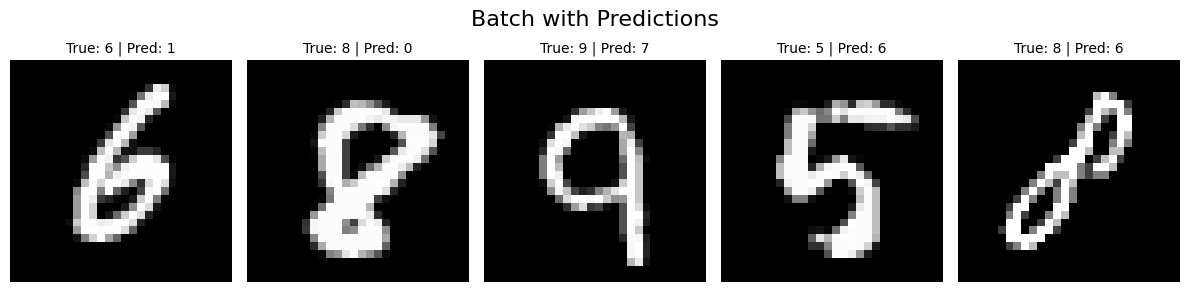

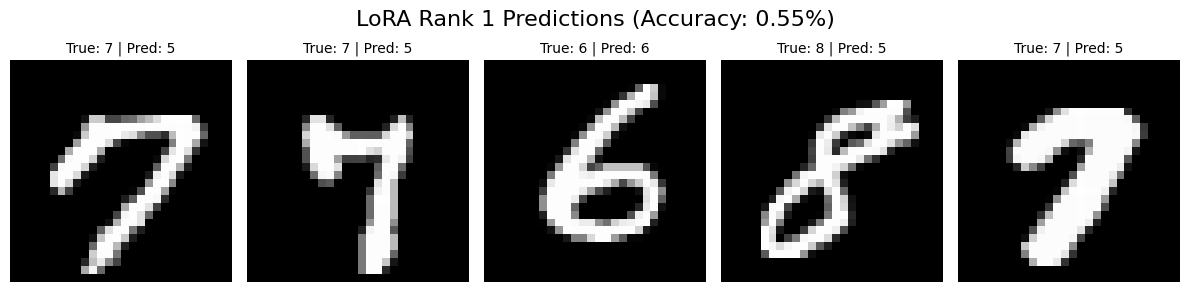

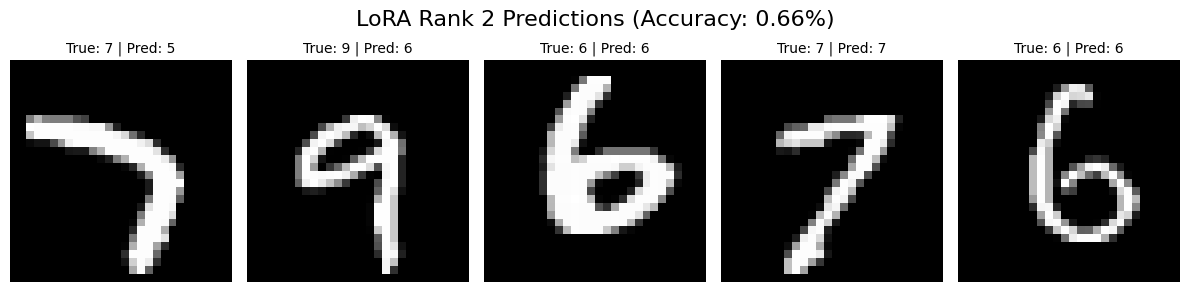

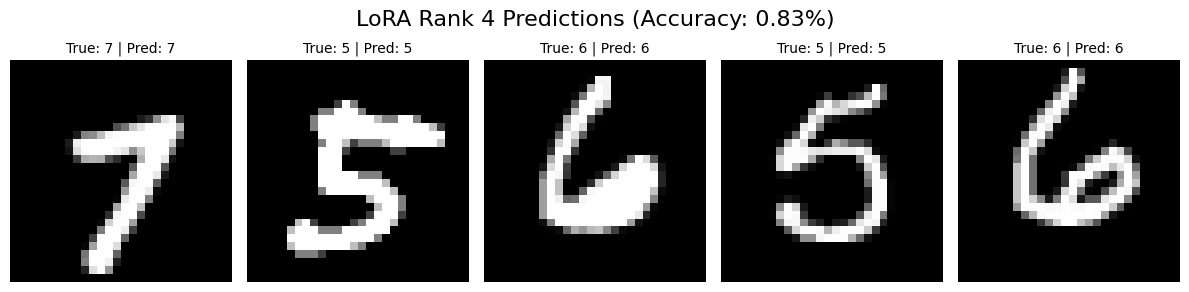

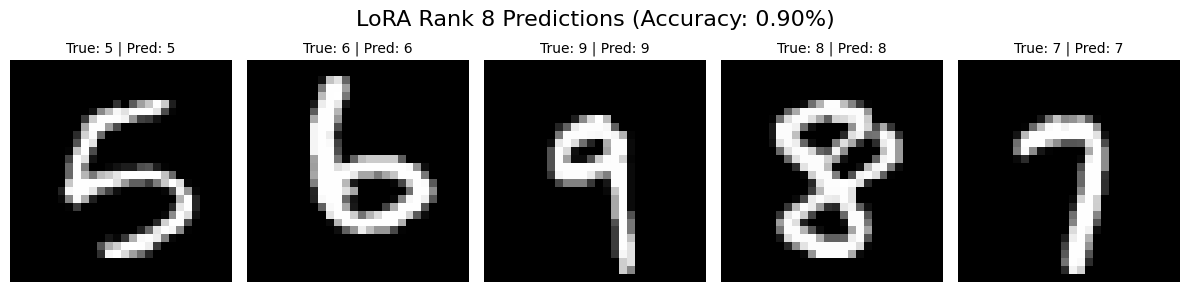

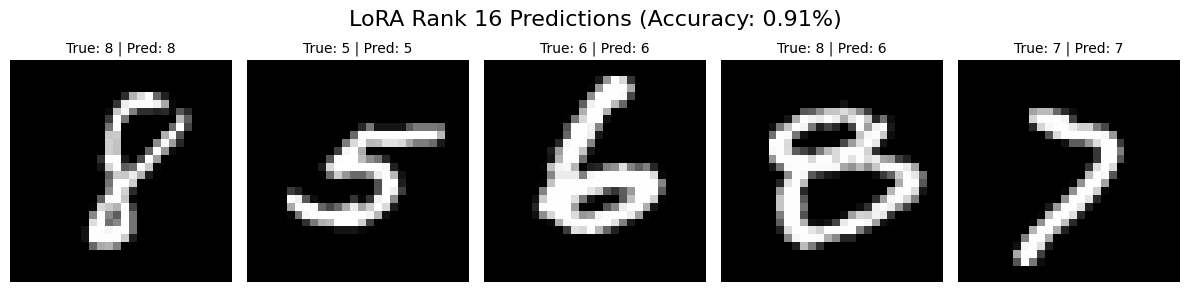

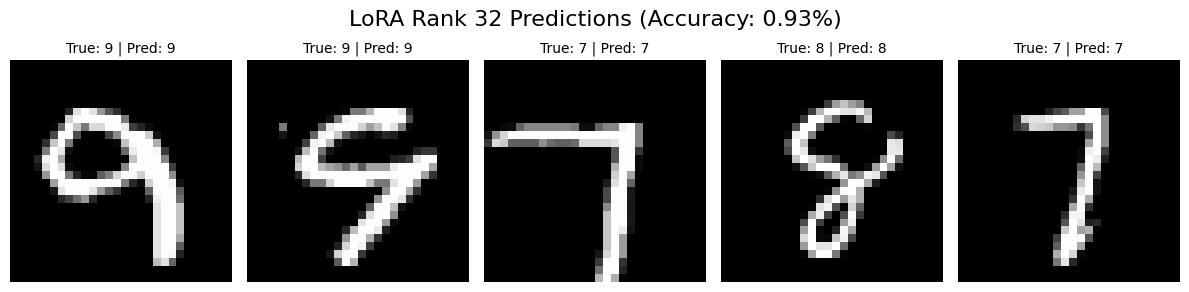

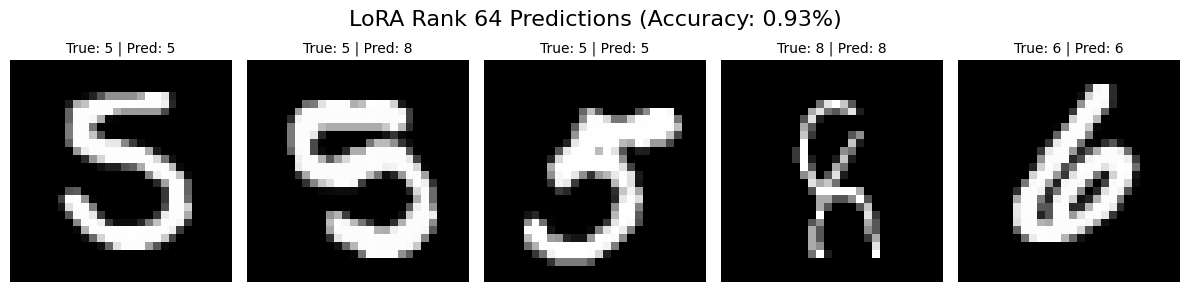

In [112]:
# Shuffle flag to control whether the dataset is shuffled or not
shuffle = True

# Get a batch of test data from the LoRA datamodule
x, y = get_batch_from_dataset(datamodule=dm_lora, batch_size=5, setup_stage="test", shuffle=shuffle)

# Visualize predictions made by the base model
title = "Base Model Predictions (Before LoRA)"
visualize_batch_with_predictions(model=model_base, x=x, y=y, title="Batch with Predictions")

# Loop through different LoRA ranks and visualize their predictions
for lora_rank in lora_ranks:
    # Get another batch of test data from the LoRA datamodule
    x, y = get_batch_from_dataset(datamodule=dm_lora, batch_size=5, setup_stage="test", shuffle=shuffle)
    
    # Retrieve the LoRA model corresponding to the current rank
    model_lora = models_lora.get(lora_rank)
    
    # Get the prediction accuracy for the current rank
    accuracy = results.get(lora_rank, "N/A")
    
    # Format the accuracy to 2 decimal places if available
    formatted_accuracy = f"{accuracy:.2f}" if accuracy != "N/A" else accuracy
    
    # Generate a descriptive title for the current visualization
    title = f"LoRA Rank {lora_rank} Predictions (Accuracy: {formatted_accuracy}%)"
    
    # Visualize predictions made by the LoRA model for the current rank
    visualize_batch_with_predictions(model=model_lora, x=x, y=y, title=title)


#### Results

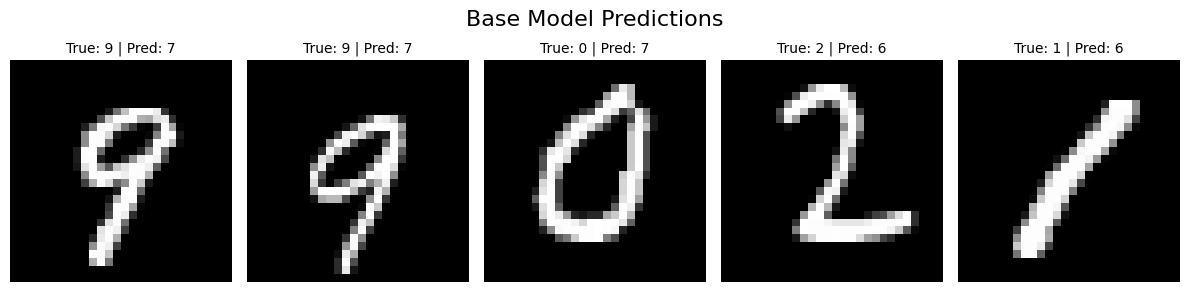

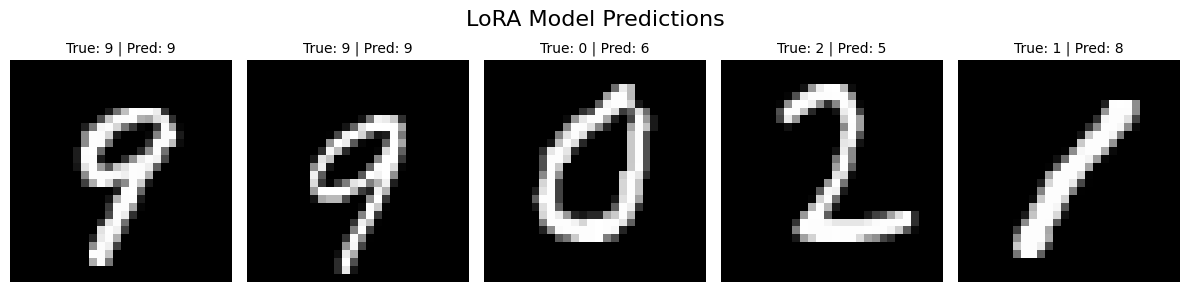

In [113]:
# Shuffle flag to control whether the dataset is shuffled or not
shuffle = True

# Get a batch of test data from the datamodule
x, y = get_batch_from_dataset(datamodule=dm_full, batch_size=5, setup_stage="test", shuffle=shuffle)

# Visualize predictions from the base model
title = "Base Model Predictions"
visualize_batch_with_predictions(model=model_base, x=x, y=y, title=title)

# Visualize predictions from the LoRA model
title = "LoRA Model Predictions (Trained on 5-9)"
visualize_batch_with_predictions(model=models_lora[lora_ranks[-1]], x=x, y=y, title=title)


### Experiment (Full Dataset)

In [118]:
# Fine-tune the model on the full dataset
model_lora_full, accuracy_full = lora_experiment(model_base_pt, MNISTLoRA, lora_rank, dm_full, max_epochs, checkpoints_dir)


C:\Users\NightFore\AppData\Local\Temp\ipykernel_135644\4107360755.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_checkpoint)
Using 16bit 


Starting LoRA fine-tuning with rank=64...


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

LoRA Rank 64 - Test Accuracy: 0.9350


#### Results

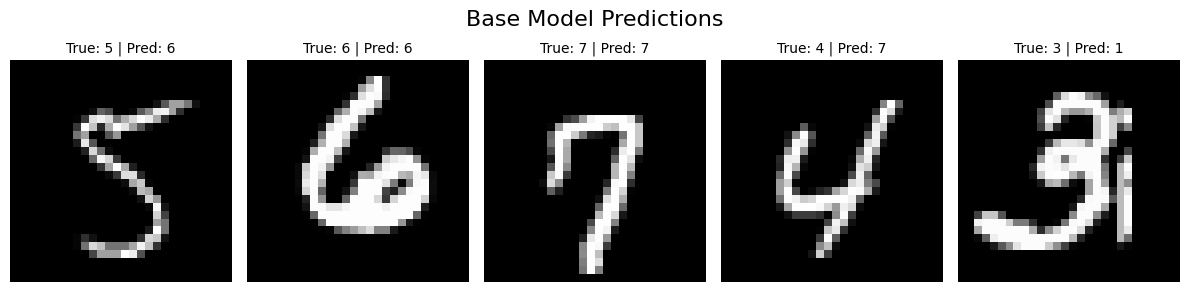

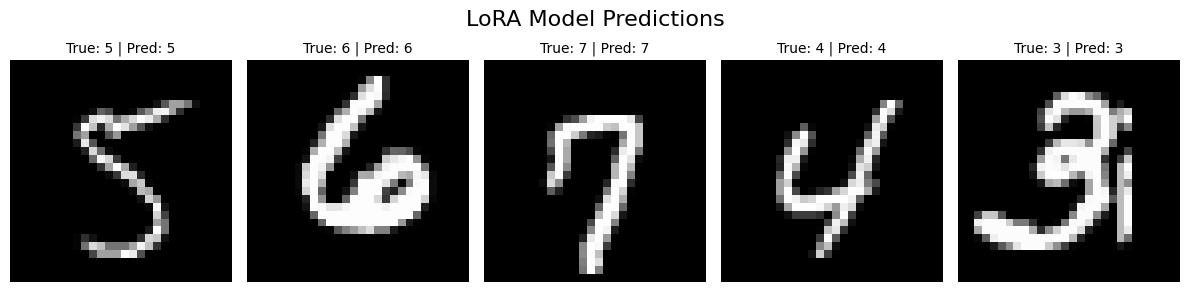

In [119]:
# Shuffle flag to control whether the dataset is shuffled or not
shuffle = True

# Get a batch of test data from the datamodule
x, y = get_batch_from_dataset(datamodule=dm_full, batch_size=5, setup_stage="test", shuffle=shuffle)

# Visualize predictions from the base model
title = "Base Model Predictions"
visualize_batch_with_predictions(model=model_base, x=x, y=y, title=title)

# Visualize predictions from the LoRA model
title = "LoRA Model Predictions (Trained on 0-9)"
visualize_batch_with_predictions(model=model_lora_full, x=x, y=y, title=title)
